In [1]:
# se importan librerias
import pandas as pd                    # dataframe
from dibuja import *                   # para plots
from dibuja2 import *                  # para plots
from regEX import *                    # expresiones regulares, clasificacion ataque
from shark import *                    # expresiones regulares, limpieza especie

In [ ]:
'''
Mi objetivo es relacionar la mortalidad y el tipo de daños causados con la 
especie de tiburon para descubrir, no solo que especie es la que genera mayor tasa de mortalidad, 
sino tambien que especie provoca mayores daños no mortales.

En una segunda parte intentare construir una serie temporal con esa informacion 
para tratar de responder una pregunta:
¿los tiburones se estan volviendo mas agresivos con el tiempo?.  
De ser cierto, ¿esta relacionado con la actividad humana?. (esta pregunta para otra ocasion)
'''


In [2]:
datos=pd.read_csv('attacks.csv', encoding='ISO-8859-1')           # se crea el dataframe
#display (datos)
#display (datos.columns)
display (datos.head())

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2018.06.25,25-Jun-2018,2018.0,Boating,USA,California,"Oceanside, San Diego County",Paddling,Julie Wolfe,F,...,White shark,"R. Collier, GSAF",2018.06.25-Wolfe.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.25,2018.06.25,6303.0,NaN,NaN
1,2018.06.18,18-Jun-2018,2018.0,Unprovoked,USA,Georgia,"St. Simon Island, Glynn County",Standing,Adyson McNeely,F,...,NaN,"K.McMurray, TrackingSharks.com",2018.06.18-McNeely.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.18,2018.06.18,6302.0,NaN,NaN
2,2018.06.09,09-Jun-2018,2018.0,Invalid,USA,Hawaii,"Habush, Oahu",Surfing,John Denges,M,...,NaN,"K.McMurray, TrackingSharks.com",2018.06.09-Denges.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.09,2018.06.09,6301.0,NaN,NaN
3,2018.06.08,08-Jun-2018,2018.0,Unprovoked,AUSTRALIA,New South Wales,Arrawarra Headland,Surfing,male,M,...,2 m shark,"B. Myatt, GSAF",2018.06.08-Arrawarra.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.08,2018.06.08,6300.0,NaN,NaN
4,2018.06.04,04-Jun-2018,2018.0,Provoked,MEXICO,Colima,La Ticla,Free diving,Gustavo Ramos,M,...,"Tiger shark, 3m",A .Kipper,2018.06.04-Ramos.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.04,2018.06.04,6299.0,NaN,NaN


In [3]:
datos=datos[['Year', 'Type', 'Activity', 'Species ', 'Injury', 'Fatal (Y/N)']]  
# se escogen los datos a tratar
# elimino el resto de columnas porque no me hacen falta para el proposito del estudio

datos=datos.rename(columns={'Year': 'Año', 'Type': 'Tipo', 'Activity': 'Actividad',\
                            'Species ': 'Especie', 'Injury': 'Daños', 'Fatal (Y/N)': 'Mortal'}) 
# renombro las columnas por comodidad

display (datos.head())

,Año,Tipo,Actividad,Especie,Daños,Mortal
0,2018.0,Boating,Paddling,White shark,"No injury to occupant, outrigger canoe and pad...",N
1,2018.0,Unprovoked,Standing,NaN,Minor injury to left thigh,N
2,2018.0,Invalid,Surfing,NaN,Injury to left lower leg from surfboard skeg,N
3,2018.0,Unprovoked,Surfing,2 m shark,Minor injury to lower leg,N
4,2018.0,Provoked,Free diving,"Tiger shark, 3m",Lacerations to leg & hand shark PROVOKED INCIDENT,N


In [4]:
datos=datos.dropna(how='all')                        # elimina Nan, desde el registro 6302 no hay datos
#print (datos.shape)
datos=datos[datos.Año>=1940]                         # una primera seleccion de datos, desde 1940
print (datos.shape)                                  # 4780 registros
#print (datos['Año'])

(4780, 6)


In [5]:
datos=datos.fillna('UNKNOWN')                                   # renombro los valores nulos...
datos=datos[datos['Especie'].map(lambda x: str(x)!='UNKNOWN')]  # ... y los elimino segun ese nombre.
datos=datos.drop_duplicates()                                   # se eliminan duplicados
datos.index=range(len(datos))                                   # reindexo el frame por si lo necesito en el futuro 
print (datos.shape)                                             # 2980 registros
null=datos.isna().sum()                                         # se miran los valores nulos
print (null[null>0])                                            # el frame esta limpio, casi

(2980, 6)
Series([], dtype: int64)


In [6]:
# clasifico el tipo de ataque: clase '0'=sin daños, '1'=daño bajo, '2'=daño medio, '3'=daño alto, '4'=mortal

datos.loc[datos['Mortal']=='Y', 'Daños']='4'                     # cambio los mortales a clase '4'
strings=[datos['Daños'][i].lower() for i in range(len(datos))]   # pasa a minusculas
datos['Clase_Daños']=regEX(strings)                              # clasificacion categorica de los ataques

datos.loc[datos['Clase_Daños']=='4', 'Mortal']='Y'  # limpio de 'UNKNOWN' la columna Mortal por la Clase_Daños
datos.loc[datos['Clase_Daños']=='3', 'Mortal']='N'
datos.loc[datos['Clase_Daños']=='2', 'Mortal']='N'
datos.loc[datos['Clase_Daños']=='1', 'Mortal']='N'
datos.loc[datos['Clase_Daños']=='0', 'Mortal']='N'
display (datos.head())

,Año,Tipo,Actividad,Especie,Daños,Mortal,Clase_Daños
0,2018.0,Boating,Paddling,White shark,"No injury to occupant, outrigger canoe and pad...",N,0
1,2018.0,Unprovoked,Surfing,2 m shark,Minor injury to lower leg,N,1
2,2018.0,Provoked,Free diving,"Tiger shark, 3m",Lacerations to leg & hand shark PROVOKED INCIDENT,N,2
3,2018.0,Unprovoked,Swimming,Tiger shark,4,Y,4
4,2018.0,Unprovoked,Fishing,"Lemon shark, 3'",Minor injury to foot. PROVOKED INCIDENT,N,1


In [7]:
# Ahora las especies

str_shark=[datos['Especie'][i].lower() for i in range(len(datos))]   # pasa a minusculas
datos['Especie(clean)']=shark(str_shark)                             # limpieza especies
display (datos.head())

,Año,Tipo,Actividad,Especie,Daños,Mortal,Clase_Daños,Especie(clean)
0,2018.0,Boating,Paddling,White shark,"No injury to occupant, outrigger canoe and pad...",N,0,White
1,2018.0,Unprovoked,Surfing,2 m shark,Minor injury to lower leg,N,1,Other
2,2018.0,Provoked,Free diving,"Tiger shark, 3m",Lacerations to leg & hand shark PROVOKED INCIDENT,N,2,Tiger
3,2018.0,Unprovoked,Swimming,Tiger shark,4,Y,4,Tiger
4,2018.0,Unprovoked,Fishing,"Lemon shark, 3'",Minor injury to foot. PROVOKED INCIDENT,N,1,Lemon


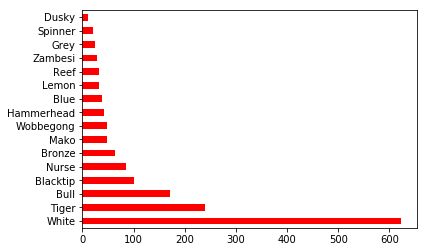

In [8]:
# plot por especie, numero de ataques

tiburones=datos['Especie(clean)'].value_counts()
tiburones[(tiburones<800) & (tiburones>10)].plot.barh(color='red')
plt.show()

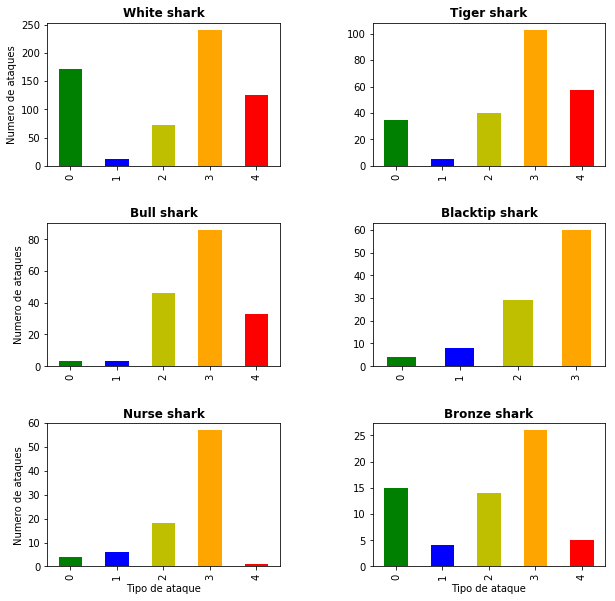

Tipo de ataque: '0'=sin daños, '1'=daño bajo, '2'=daño medio, '3'=daño alto, '4'=mortal	        	                Plots de las 6 especies de tiburón que más atacan.


In [9]:
# plots tipo de ataque y especie (blanco, tigre, toro, punta negra, nodriza, bronce)

plt.rcParams["figure.figsize"]=(10,10)          # ajuste de tamaño completo
print(dibuja(datos))                            # subplots de 6 especies


In [10]:
# creo un dataframe del porcentaje de cada tipo de ataque segun especie

pd.options.display.float_format = '{:.2f}'.format         # formato con dos decimales en pandas

ataque_w=datos[datos['Especie(clean)'].isin(['White'])]["Clase_Daños"].value_counts().sort_index()
total_w=ataque_w.sum()

ataque_t=datos[datos['Especie(clean)'].isin(['Tiger'])]["Clase_Daños"].value_counts().sort_index()
total_t=ataque_t.sum()

ataque_bu=datos[datos['Especie(clean)'].isin(['Bull'])]["Clase_Daños"].value_counts().sort_index()
total_bu=ataque_bu.sum()

ataque_bl=datos[datos['Especie(clean)'].isin(['Blacktip'])]["Clase_Daños"].value_counts().sort_index()
total_bl=ataque_bl.sum()

ataque_n=datos[datos['Especie(clean)'].isin(['Nurse'])]["Clase_Daños"].value_counts().sort_index()
total_n=ataque_n.sum()

ataque_br=datos[datos['Especie(clean)'].isin(['Bronze'])]["Clase_Daños"].value_counts().sort_index()
total_br=ataque_br.sum()

tipo_ataque=pd.DataFrame(columns=['White', 'Tiger', 'Bull', 'Blacktip', 'Nurse', 'Bronze'])

tipo_ataque['White']=[ataque_w[i]*100/total_w for i in range(len(ataque_w))]
tipo_ataque['Tiger']=[ataque_t[i]*100/total_t for i in range(len(ataque_t))]
tipo_ataque['Bull']=[ataque_bu[i]*100/total_bu for i in range(len(ataque_bu))] 
tipo_ataque['Blacktip']=pd.Series([ataque_bl[i]*100/total_bl for i in range(len(ataque_bl))])
tipo_ataque=tipo_ataque.fillna('0')        # he de hacer esto porque las longitudes no coinciden
tipo_ataque['Nurse']=[ataque_n[i]*100/total_n for i in range(len(ataque_n))]
tipo_ataque['Bronze']=[ataque_br[i]*100/total_br for i in range(len(ataque_br))]

tipo_ataque=tipo_ataque.transpose()
tipo_ataque=tipo_ataque.rename(columns={0:'%-Sin daños', 1:'%-Daño bajo',\
                                        2:'%-Daño medio', 3:'%-Daño alto', 4:'%-Mortal'})  

display (tipo_ataque)
tipo_ataque.to_csv('tipo_ataque(6-especies).csv')  # guardo este dataframe

,%-Sin daños,%-Daño bajo,%-Daño medio,%-Daño alto,%-Mortal
White,27.45,2.09,11.56,38.68,20.22
Tiger,14.58,2.08,16.67,42.92,23.75
Bull,1.75,1.75,26.90,50.29,19.30
Blacktip,3.96,7.92,28.71,59.41,0
Nurse,4.65,6.98,20.93,66.28,1.16
Bronze,23.44,6.25,21.88,40.62,7.81


In [ ]:
'''
Una primera conclusión es que, en contra de lo que pudiera parecer, no es el tiburón blanco el que tiene 
una mayor tasa de mortalidad, sino el tiburón tigre. Por supuesto, el tiburon blanco ataca unas tres veces
más que el tiburón tigre, y en términos absolutos mata a más personas, pero el tiburón tigre tiene un 3,5% más 
de ataques mortales en términos relativos.
Es interesante observar que el tiburón blanco tiene la mayor tasa de ataques sin daños, lo cual puede ser debido 
a su comportamiento de morder para probar antes de decidir si la presa es buena.
Por otro lado, tampoco es el tiburón blanco el que más daños provoca en sus ataques. En el caso de las lesiones
graves y leves, el tiburón que más daños causa es el tiburón nodriza, y en el caso de lesiones de tipo medio es
el tiburón de punta negra. De éste último no existen registros de ataques mortales, aunque también tiene un alto
porcentaje de lesiones graves en sus víctimas.
Ahora intentaré observar como cambian estos datos con el tiempo. 
'''

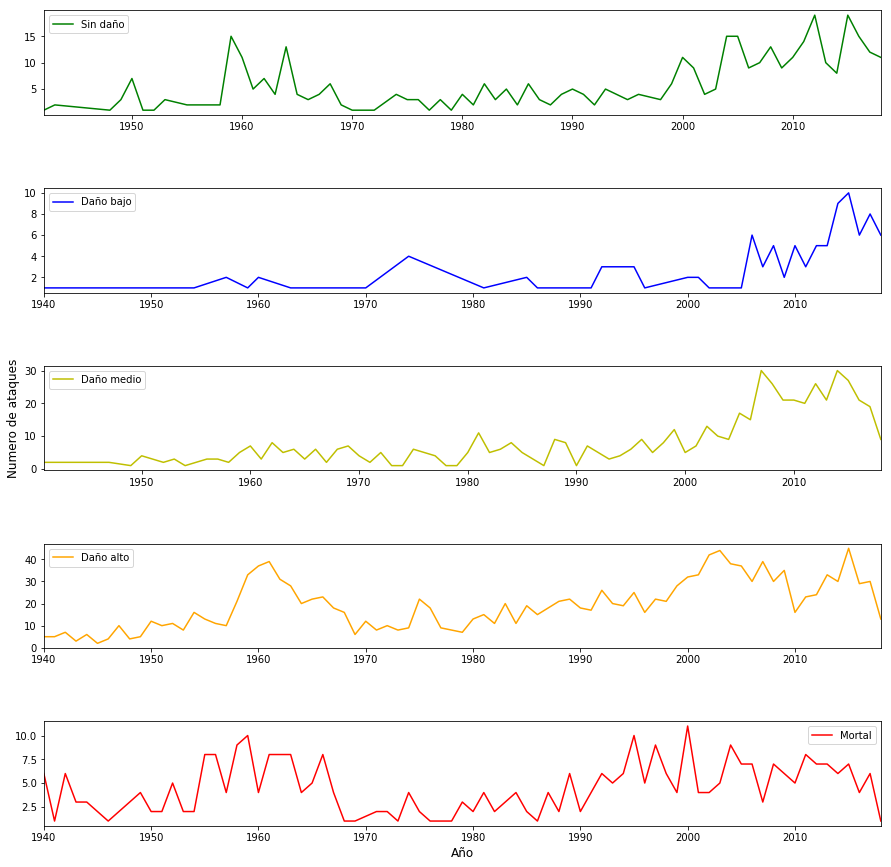

In [11]:
# plots nº ataques vs tiempo segun tipo de daños

plt.rcParams["figure.figsize"]=(15,15)          # ajuste de tamaño completo
print (dibuja2(datos))                          # subplots temporales segun tipo de daños

In [ ]:
'''
He intentado hacer una regresión lineal en cada plot para ver la pendiente, pero aún no se hacerlo con 
pandas.plot, no es como con numpy. Dicha pendiente sería un buen indicador.
Sin embargo, puede observarse un repunte en las dos últimas décadas de los ataques sin daño, con daño bajo y 
daño medio. Las series de daño alto y mortal parecen ser estacionarias, que oscilan alrededor de un valor.
Con esto es complicado llegar a una buena conclusión. Pudiera ser que actualmente se recogen más y mejores
datos, que el registro es más amplio. También pudiera ser que efectivamente los tiburones han atacado más en 
las dos últimas décadas, aunque de ser así lo han de hecho de una manera menos agresiva. También es posible
que el cambio climático y el aumento de la población humana conlleve un mayor número de ataques. Asi pues, 
¿los tiburones se estan volviendo mas agresivos con el tiempo?, sería necesario un nuevo estudio para llegar 
a una conclusión en firme.

Por último, y no menos importante, pues es el objetivo primero de éste proyecto, se extrae el dataframe limpio.
'''

In [12]:
# se exporta el dataframe limpio
# ahora elimino tambien el Tipo y la Actividad, pues no lo he utilizado en el estudio
attacks_clean=pd.DataFrame()
attacks_clean['Year']=datos['Año'].astype('int64')
attacks_clean['Species']=datos['Especie(clean)']
attacks_clean['Injury']=datos['Daños']
attacks_clean['Injury_Class']=datos['Clase_Daños']
attacks_clean['Fatal (Y/N)']=datos['Mortal']
attacks_clean.loc[attacks_clean['Injury']=='4', 'Injury']='FATAL' 
display(attacks_clean.head())
attacks_clean.to_csv('attacks(clean).csv')

,Year,Species,Injury,Injury_Class,Fatal (Y/N)
0,2018,White,"No injury to occupant, outrigger canoe and pad...",0,N
1,2018,Other,Minor injury to lower leg,1,N
2,2018,Tiger,Lacerations to leg & hand shark PROVOKED INCIDENT,2,N
3,2018,Tiger,FATAL,4,Y
4,2018,Lemon,Minor injury to foot. PROVOKED INCIDENT,1,N
